In [1]:
from tensorflow.keras.models import Model

In [3]:
from tensorflow.keras.layers import (
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AvgPool1D, AvgPool2D, Reshape,
    Input, Activation, BatchNormalization, Dense, Add, Lambda, Dropout, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [8]:
import numpy as np
import pandas as pd
import pickle

In [25]:
import matplotlib.pyplot as plt

In [4]:
min_idx_y = 71
max_idx_y = 150
num_classes_y = max_idx_y - min_idx_y + 1

In [5]:
def crps(y_true, y_pred):
    loss = K.mean(K.sum((K.cumsum(y_pred, axis = 1) - K.cumsum(y_true, axis=1))**2, axis=1))/199
    return loss

In [41]:
def get_conv_net(num_classes_y):
    #_, x, y, z = train_x.shape
    inputdense_players = Input(shape=(11,10,10), name = "playersfeatures_input")
    
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
    X = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    
    # The second block of convolutions learns the necessary information per defense player before the aggregation.
    # For this reason the pool_size should be (1, 10). If you want to learn per off player the pool_size must be 
    # (11, 1)
    Xmax = MaxPooling2D(pool_size=(1,10))(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool2D(pool_size=(1,10))(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,2))(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(160, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    
    Xmax = MaxPooling1D(pool_size=11)(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool1D(pool_size=11)(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,1))(X)
    
    X = Dense(96, activation="relu")(X)
    X = BatchNormalization()(X)

    X = Dense(256, activation="relu")(X)
    X = LayerNormalization()(X)
    #X = Dropout(0.3)(X)

    outsoft = Dense(num_classes_y, activation='softmax', name = "output")(X)

    model = Model(inputs = [inputdense_players], outputs = outsoft)
    return model

In [22]:
with open('X_tensor.data', 'rb') as f:
    X_tensor = pickle.load(f)
with open('y_tensor.data', 'rb') as f:
    y_tensor = pickle.load(f).astype('float32')

In [31]:
def run_model(X_tensor, y_tensor, n_epochs, batch_size, lr):
    model = get_conv_net(num_classes_y)
    n_epochs = 30

    opt = Adam(learning_rate=lr)
    model.compile(loss=crps,
                  optimizer=opt)

    history = model.fit(X_tensor,
                      y_tensor, 
                      epochs=n_epochs,
                      batch_size=batch_size,
                      verbose=1,
                      validation_split=0.2)
    return history


In [34]:
def plot_loss(history, batch_size, lr):
    plt.title(f"Learning Curve Batch Size {batch_size} Learning Rate {lr}")
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    

In [43]:
history_lr001_b10 = run_model(X_tensor, y_tensor, 30, 10, 0.001)

Epoch 1/30
222/222 [==============================] - 6s 18ms/step - loss: 0.0240 - val_loss: 0.0341
Epoch 2/30
222/222 [==============================] - 4s 16ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 3/30
222/222 [==============================] - 4s 17ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 4/30
222/222 [==============================] - 4s 16ms/step - loss: 0.0212 - val_loss: 0.0211
Epoch 5/30
222/222 [==============================] - 4s 17ms/step - loss: 0.0209 - val_loss: 0.0330
Epoch 6/30
222/222 [==============================] - 4s 18ms/step - loss: 0.0208 - val_loss: 0.0236
Epoch 7/30
222/222 [==============================] - 4s 17ms/step - loss: 0.0208 - val_loss: 0.0201
Epoch 8/30
222/222 [==============================] - 4s 18ms/step - loss: 0.0203 - val_loss: 0.0235
Epoch 9/30
222/222 [==============================] - 4s 17ms/step - loss: 0.0202 - val_loss: 0.0210
Epoch 10/30
222/222 [==============================] - 4s 17ms/step - loss: 0.0204 - val_lo

In [ ]:
history_lr001_e30 = run_model(X_tensor, y_tensor, 30, 64, 1e-3)

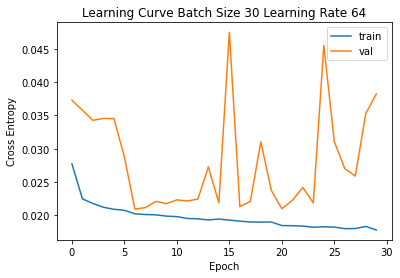

In [35]:
plot_loss(history_lr001_e30, 30, 64)

In [ ]:
history_lr001_b10 = run_model(X_tensor, y_tensor, 30, 10, 1e-3)

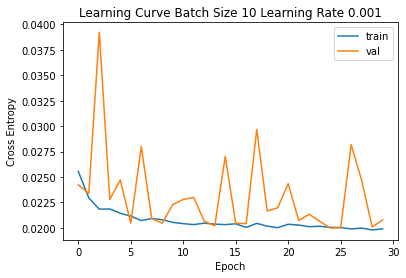

In [37]:
plot_loss(history_lr001_b10, 10, 0.001)